<a href="https://colab.research.google.com/github/Maviya5/CE888/blob/master/assignment/Google_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import json
from pandas.io.json import json_normalize

In [24]:
import os

os.environ['KAGGLE_USERNAME'] = "maviya" # username from the json file

os.environ['KAGGLE_KEY'] = "83f6fca6b904ceddb229178c8bef1e62" # key from the json file

!kaggle competitions download -c ga-customer-revenue-prediction # api copied from kaggle

sample_submission.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
sample_submission_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
test_v2.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
train.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#For zip file
from zipfile import ZipFile
file_name = "train.csv.zip"
file_name = "test.csv.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()


In [0]:
#loading the train and test data
def load_df(csv_path='train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path, 
                     converters={column: json.loads for column in JSON_COLUMNS}, 
                     dtype={'fullVisitorId': 'str'}, 
                     nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

In [35]:
print('Loading Train set...')
train = load_df("train.csv")


Loading Train set...
Loaded train.csv. Shape: (903653, 55)


In [38]:
print('Loading Test set...')
test = load_df("test.csv")

Loading Test set...
Loaded test.csv. Shape: (804684, 53)


In [39]:
train.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.bounces,totals.newVisits,totals.transactionRevenue,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.isTrueDirect,trafficSource.referralPath,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.adContent,trafficSource.campaignCode
0,Organic Search,20160902,1131660440785968503,1131660440785968503_1472830385,Not Socially Engaged,1472830385,1,1472830385,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Western Asia,Turkey,Izmir,(not set),Izmir,not available in demo dataset,ttnet.com.tr,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20160902,377306020877927890,377306020877927890_1472880147,Not Socially Engaged,1472880147,1,1472880147,Firefox,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Oceania,Australasia,Australia,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,dodo.net.au,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20160902,3895546263509774583,3895546263509774583_1472865386,Not Socially Engaged,1472865386,1,1472865386,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Community of Madrid,(not set),Madrid,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,1,1,1,1,NaN,(not set),google,organic,(not provided),not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20160902,4763447161404445595,4763447161404445595_1472881213,Not Socially Engaged,1472881213,1,1472881213,UC Browser,not available in demo dataset,not available in demo dataset,Linux,not available in demo dataset,False,not ava

In [40]:
test.head()

,channelGrouping,date,fullVisitorId,sessionId,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.newVisits,totals.bounces,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.keyword,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.referralPath,trafficSource.adContent
0,Organic Search,20171016,6167871330617112363,6167871330617112363_1508151024,Not Socially Engaged,1508151024,2,1508151024,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Asia,Southeast Asia,Singapore,(not set),(not set),(not set),not available in demo dataset,myrepublic.com.sg,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,4,4,NaN,NaN,(not set),google,organic,(not provided),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Organic Search,20171016,0643697640977915618,0643697640977915618_1508175522,Not Socially Engaged,1508175522,1,1508175522,Chrome,not available in demo dataset,not available in demo dataset,Windows,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Southern Europe,Spain,Aragon,(not set),Zaragoza,not available in demo dataset,rima-tde.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,5,5,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Organic Search,20171016,6059383810968229466,6059383810968229466_1508143220,Not Socially Engaged,1508143220,1,1508143220,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Europe,Western Europe,France,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,sfr.net,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,7,7,1,NaN,(not set),google,organic,(not provided),NaN,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Organic Search,20171016,2376720078563423631,2376720078563423631_1508193530,Not Socially Engaged,1508193530,1,1508193530,Safari,not available in demo dataset,not available in demo dataset,iOS,not available in demo dataset,True,not available in demo dataset,not available in demo dataset,not available in dem

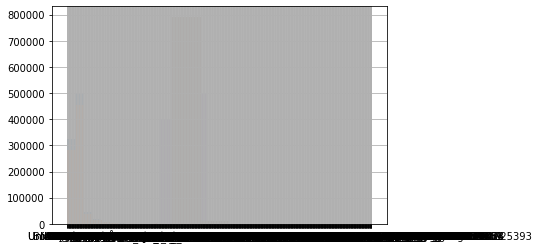

In [43]:
train['geoNetwork.country'].hist() 
test['geoNetwork.country'].hist()
train["trafficSource.adContent"].hist() 
test['trafficSource.adContent'].hist()
train["trafficSource.source"].hist() 
test['trafficSource.source'].hist()

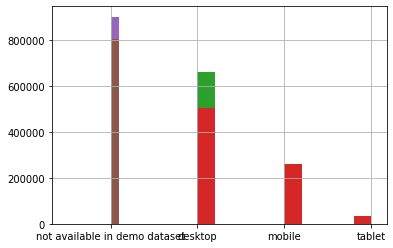

In [42]:
train['device.browserVersion'].hist() 
test['device.browserVersion'].hist()
train["device.deviceCategory"].hist() 
test['device.deviceCategory'].hist()
train["device.flashVersion"].hist() 
test['device.flashVersion'].hist()

In [44]:
#imputing missing values
print('Imputing missing values...')
for i in train.columns:
    if train[i].dtype == 'object':
      train[i] = train[i].fillna(train[i].mode().iloc[0])
    elif (train[i].dtype != 'object'):
      train[i] = train[i].fillna(np.mean(train[i]))


for i in test.columns:
    if test[i].dtype == 'object':
      test[i] = test[i].fillna(test[i].mode().iloc[0])
    elif (test[i].dtype != 'object'):
      test[i] = test[i].fillna(np.mean(test[i]))
    

print('Nulls in train set:', train.isnull().sum().sum())
print('Nulls in test set:', test.isnull().sum().sum())

Imputing missing values...
Nulls in train set: 0
Nulls in test set: 0


In [45]:
#for categorical variables
print('Label Encoding categorical variables...')
for col in train.columns:
    if train[col].dtype == 'object':
      train[col] = train[col].astype('category')
      train[col] = train[col].cat.codes

for col in test.columns:
    if test[col].dtype == 'object':
      test[col] = test[col].astype('category')
      test[col] = test[col].cat.codes

Label Encoding categorical variables...


In [0]:
train['set'] = 0
test['set'] = 1
train = train.drop(['totals.transactionRevenue', 'trafficSource.campaignCode'],axis=1)

In [47]:
train_df = train.sample(10000, random_state=697)
test_df = test.sample(10000, random_state=466)

all_data = train_df.append(test_df)
y_label = all_data['set']
all_data = all_data.drop('set',axis=1)


print('New dataframe shape:', all_data.shape)

New dataframe shape: (20000, 53)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


In [48]:
model = RandomForestClassifier(n_estimators = 50, max_depth = 5, min_samples_leaf = 5)
feat_to_drop = []
for col in all_data.columns:
    score = cross_val_score(model,pd.DataFrame(all_data[col]),y_label,cv=4,scoring='roc_auc')
    if np.mean(score) > 0.8:
        feat_to_drop.append(col)
    print(col,np.mean(score))

channelGrouping 0.57437524
date 1.0
device.browser 0.99938902
device.browserSize 0.5
device.browserVersion 0.5
device.deviceCategory 0.55224268
device.flashVersion 0.5
device.isMobile 0.55175
device.language 0.5
device.mobileDeviceBranding 0.5
device.mobileDeviceInfo 0.5
device.mobileDeviceMarketingName 0.5
device.mobileDeviceModel 0.5
device.mobileInputSelector 0.5
device.operatingSystem 0.89182542
device.operatingSystemVersion 0.5
device.screenColors 0.5
device.screenResolution 0.5
fullVisitorId 0.5719487999999999
geoNetwork.city 0.95803336
geoNetwork.cityId 0.5
geoNetwork.continent 0.52187666
geoNetwork.country 0.9154802800000001
geoNetwork.latitude 0.5
geoNetwork.longitude 0.5
geoNetwork.metro 0.94167192
geoNetwork.networkDomain 0.7921310399999999
geoNetwork.networkLocation 0.5
geoNetwork.region 0.7039368400000001
geoNetwork.subContinent 0.54118368
sessionId 0.55714012
socialEngagementType 0.5
totals.bounces 0.5
totals.hits 0.7678136
totals.newVisits 0.5
totals.pageviews 0.80986176

In [49]:
print('Number of features with covariate shift:', len(feat_to_drop))

Number of features with covariate shift: 14


In the given data the covariate shift is seen in 14 features